In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torchdiffeq import odeint

import matplotlib.pyplot as plt


In [ ]:
data=pd.read_csv('../data/VCB.csv')

In [16]:
data.head(10)

,Unnamed: 0.1,Unnamed: 0,time,open,high,low,close,volume
0,0,0,2018-01-02,22.98,23.58,22.81,23.41,2801720
1,1,1,2018-01-03,23.62,23.71,23.20,23.37,1843870
2,2,2,2018-01-04,23.24,23.58,23.11,23.58,1990040
3,3,3,2018-01-05,23.45,23.45,22.94,22.98,2045200
4,4,4,2018-01-08,22.98,23.62,22.56,23.58,2071140
5,5,5,2018-01-09,23.83,24.90,23.20,24.90,2853160
6,6,6,2018-01-10,24.81,25.20,24.39,24.69,2842830
7,7,7,2018-01-11,24.47,25.03,24.35,25.03,1766240
8,8,8,2018-01-12,25.03,25.28,24.69,24.69,2525840
9,9,9,2018-01-15,24.69,25.54,24.26,25.54,2061850


C:\Users\DELL\AppData\Local\Temp\ipykernel_1912\1121445975.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


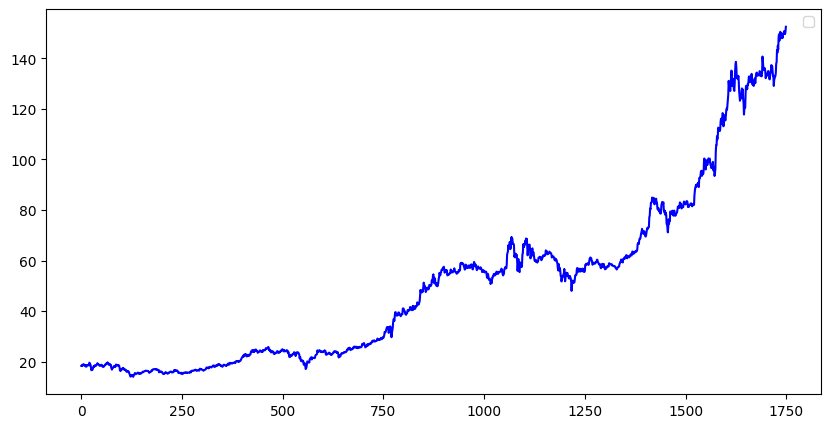

In [3]:
plt.figure(figsize=(10, 5))  #
plt.plot(data[['close']],color='blue')   #
plt.legend()
plt.show()

In [3]:
def process_data(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    #Lấy cột Close
    data=data[['close']]

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=False)

    # Khởi tạo scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit scaler trên tập huấn luyện và transform cả train lẫn test
    train_scaled = scaler.fit_transform(x_train)
    test_scaled = scaler.transform(x_test)

    #Tạo vòng lặp giá trị, lấy 50 ngày trong quá khứ để dự đoán ngày tiếp theo
    x_train = []
    y_train = []
    for i in range(60, len(train_scaled)):
        x_train.append(train_scaled[i-60:i, 0])
        y_train.append(train_scaled[i, 0])

    x_test = []
    y_test = []
    for i in range(60, len(test_scaled)):
        x_test.append(test_scaled[i-60:i, 0])
        y_test.append(test_scaled[i, 0])

    #Chuyển dạng list sang dạng mảng numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    #Xếp dữ liệu thành mảng 1 chiều
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, test_scaled

In [4]:
#Model NODE
class ODEfunc(nn.Module):
    def __init__(self, input_size):
        super(ODEfunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),        #Kích thước đầu vào (số tính năng)
            nn.Tanh(),
            nn.Linear(128, input_size)
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODE(nn.Module):
    def __init__(self, odefunc, num_feature):
        super(NeuralODE, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0,1]).float()


    def forward(self, x):
        out = odeint(self.odefunc, x, self.integration_time)
        out = out[1]
        out = out[:,-1,:]
        return out


def train_NeuralODE(model, x_train, y_train,x_test, y_test ,epochs=100, lr=0.01, patience=10):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    y_train = y_train.squeeze()
    y_test = y_test.squeeze()

    best_val_loss = float('inf')
    best_model = None
    patience_count = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()     #Xóa gradients từ bước trước
        prediction = model(x_train).squeeze()
        loss = criterion(prediction, y_train)
        loss.backward()
        optimizer.step()    #Cập nhật tham số mô hình

        model.eval()
        with torch.no_grad():
            val_prediction = model(x_test).squeeze()
            val_loss = criterion(val_prediction, y_test)

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model = model.state_dict()
            patience_count = 0
        else:
            patience_count +=1

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Training loss: {loss.item()}, Val loss: {val_loss.item()}')

        if patience_count > patience:
            print(f'Early stopping at epoch {epoch}')
            break

    if model is not None:
        model.load_state_dict(best_model)

    return model

In [19]:
x_train, y_train, x_test, y_test, scaler, test_scaled = process_data(data)

In [23]:
#MWG
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.04087458923459053, Val loss: 0.17095045745372772
Epoch 10, Training loss: 0.04202115535736084, Val loss: 0.008545332588255405
Epoch 20, Training loss: 0.006641922518610954, Val loss: 0.001877258182503283
Epoch 30, Training loss: 0.005417205858975649, Val loss: 0.012587374076247215
Early stopping at epoch 35


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [16]:
#MSFT 
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.10568804293870926, Val loss: 0.15666019916534424
Epoch 10, Training loss: 0.022736670449376106, Val loss: 0.1876259446144104
Epoch 20, Training loss: 0.012433076277375221, Val loss: 0.0019099368946626782
Epoch 30, Training loss: 0.0026759179309010506, Val loss: 0.007112317718565464
Epoch 40, Training loss: 0.0012292261235415936, Val loss: 0.00895143486559391
Epoch 50, Training loss: 0.00047782633919268847, Val loss: 0.0016550804721191525
Early stopping at epoch 59


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
#VCB
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.08164645731449127, Val loss: 0.1559152752161026
Epoch 10, Training loss: 0.022522425279021263, Val loss: 0.1801123470067978
Early stopping at epoch 16


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [53]:
#FPT
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.029810134321451187, Val loss: 0.27764230966567993
Epoch 10, Training loss: 0.05618874728679657, Val loss: 0.41424497961997986
Early stopping at epoch 14


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [16]:
#BID
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.02651807852089405, Val loss: 0.314457505941391
Epoch 10, Training loss: 0.03534689545631409, Val loss: 0.20999754965305328
Early stopping at epoch 14


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [14]:
#HPG
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.028008664026856422, Val loss: 0.2539688050746918
Epoch 10, Training loss: 0.05707075819373131, Val loss: 0.0035528442822396755
Epoch 20, Training loss: 0.018991846591234207, Val loss: 0.011218663305044174
Epoch 30, Training loss: 0.005316037219017744, Val loss: 0.00047513117897324264
Early stopping at epoch 35


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
torch.save(node_model, '../model/NODE-VCB-128.pth')

In [ ]:
node_model = torch.load('../model/NODE-VCB-128.pth', weights_only=False)

In [13]:
print(node_model)

NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [ ]:
test_tensor = torch.from_numpy(x_test).float()
predict = node_model(test_tensor).detach().numpy()
predict = predict.squeeze()

In [ ]:
#MWG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.05608572297156037
MAE:  0.053583596103729154
R-squared:  0.8881664657986891


In [ ]:
#MSFT 
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.024243948226809312
MAE:  0.018392591225291598
R-squared:  0.9234566638216076


In [ ]:
#FPT
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.13832886921561133
MAE:  0.1242708690219694
R-squared:  0.8776634805300743


In [ ]:
#VCB
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.16609816006033665
MAE:  0.16370830046182847
R-squared:  -8.834051027858473


In [ ]:
#BID
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.1693735034961331
MAE:  0.15977936706316917
R-squared:  -0.810148529005174


In [ ]:
#HPG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.030953721390607997
MAE:  0.028266837587235704
R-squared:  0.4913989747926185


In [ ]:
prediction_test_price = scaler.inverse_transform(predict.reshape(-1, 1))
actual_test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

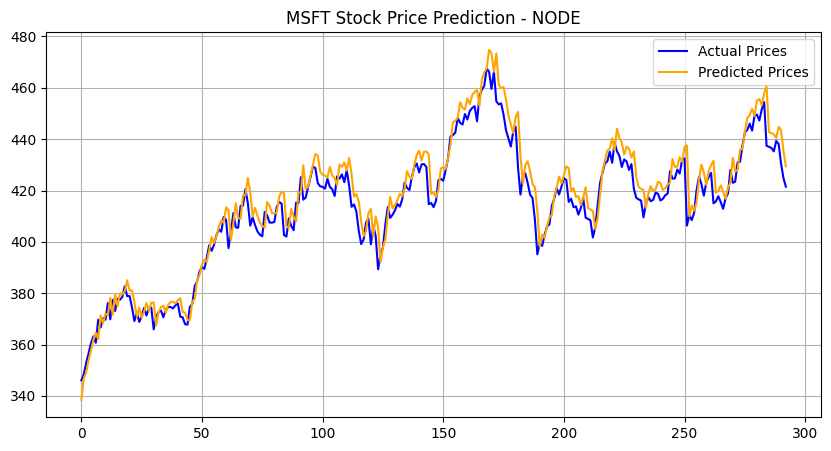

In [20]:
#Vẽ biểu đồ MSFT 60ngay

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

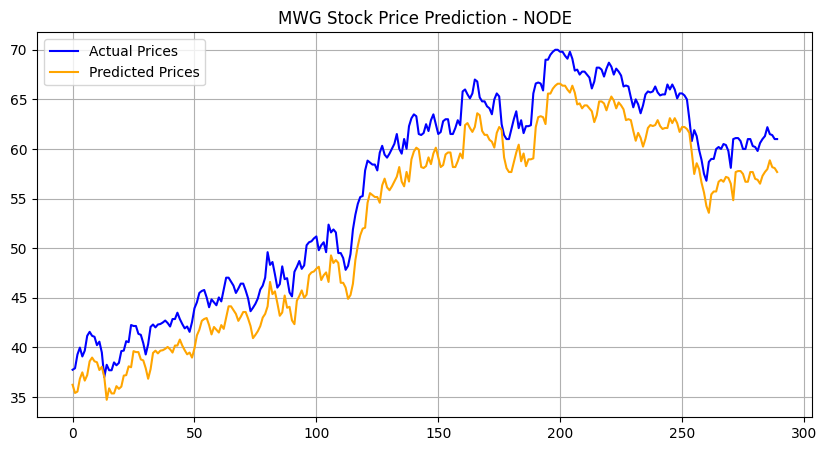

In [27]:
#Vẽ biểu đồ 

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

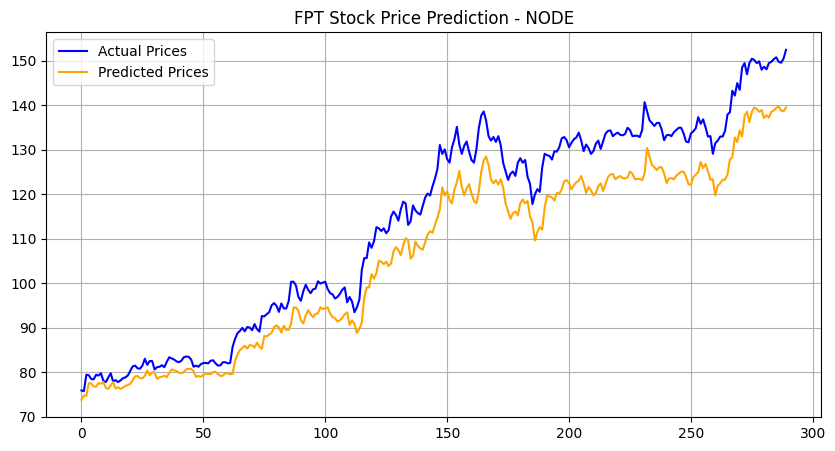

In [58]:
#Vẽ biểu đồ 

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

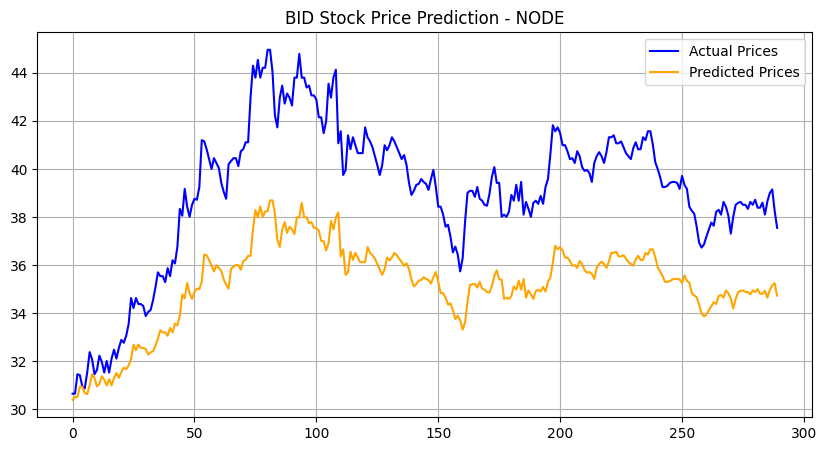

In [21]:
#Vẽ biểu đồ BID

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

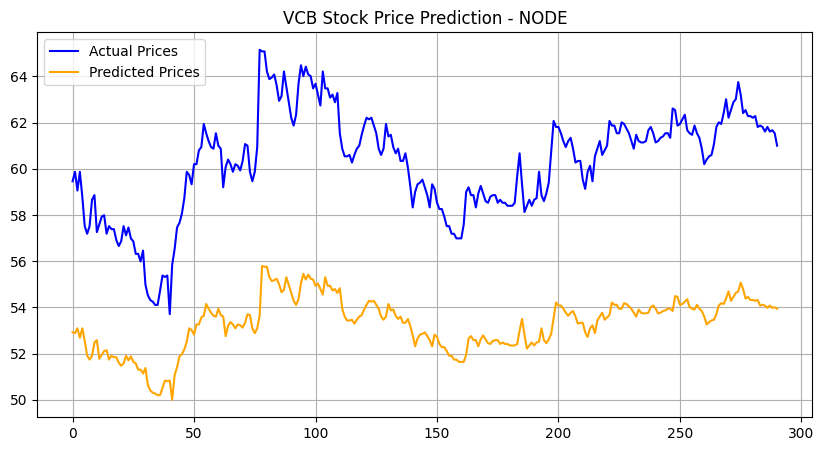

In [29]:
#Vẽ biểu đồ 

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

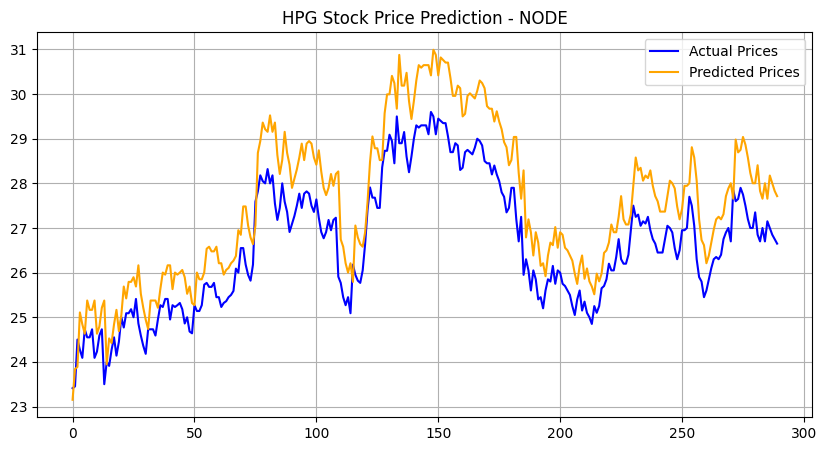

In [19]:
#Vẽ biểu đồ HPG

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()